# Sample Size Experiment using Random Forest and Deep Networks

### Random Forest (RF) vs. Deep Networks (DN)

Random forest is inherently a non-parametric model, meaning that the algorithm requires no assumptions about the data distribution. With infinitely many trees and n -> $\infty$, RF will follow non-parametric behavior and will guarantee convergence.

Deep Networks with a fixed architecture are entirely parametric. As presented by [Vogelstein, et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.29.068460v1), there is a clear bias variance tradeoff between DNs as the number of parameters change. This is evident by testing each model over a range of sample sizes. DNs (CNNs) perform particularly well on image datasets. 

### Experiment Discription

In [Vogelstein, et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.29.068460v1), when trained on the CIFAR-10 dataset, both a simple DN and an overparametrized DN produced a lower classification error than RF for sample sizes greater than 2500. RF outperformed both DNs for sample sizes smaller than 2500. While this experiment only tests up to 10000 sample sizes, RF is theoretically guaranteed to produce a lower classification error at infinite samples due to its non-parametric nature.

The goal of this tutorial is to identify a joint distribution (X,Y) that demonstrates this relationship. RF should profuce a smaller generalization error as small sample sizes, a specific parametric DN should produce a smaller generalization error at medium sample sizes, and RF should once again produce a smaller generalization error at large sample sizes.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Load dependencies

Import required dependencies and model functions from sample_size_experiment.py

In [2]:
from sample_size_experiment import *

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import display

from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

<IPython.core.display.Javascript object>

### Randomly sample subset of points

Function takes in X and y data. Randomly select a desired number of indices and outputs the data in those positions.

In [4]:
from random import sample


def random_sample(X, y, samples):

    ordered_indices = [num for num in range(samples)]
    random_indices = sample(ordered_indices, samples)

    X = X[random_indices]
    y = y[random_indices]

    return X, y

<IPython.core.display.Javascript object>

### Testing suite

Testing function. Creates a DNN and a RF model based on the function attributes. Fits the models to the inputted data. Reruns model over a range of sample sizes for X, y data stored in the attribute sample_sizes. Reruns the entire testing suite for an inputted number of iterations to average out classification error.

In [5]:
from sklearn.model_selection import train_test_split


def test_suite(
    X,
    y,
    iterations,
    output_nodes,
    sample_sizes=[500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000],
    num_trees=100,
    max_depth=None,
    rf_verbose=1,
    epochs=10,
    batch_size=50,
    learning_rate=0.001,
    validation_split=0.3,
    dnn_verbose=1,
):

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    rf_evolution = np.zeros((len(sample_sizes), iterations))
    dnn_evolution = np.zeros((len(sample_sizes), iterations))

    for iteration in range(iterations):
        print("iteration: ", iteration)

        for sample_size_index, max_sample_size in enumerate(sample_sizes):
            print("Max sample size: ", max_sample_size)

            X_scaled, y_scaled = random_sample(X, y, max_sample_size)
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y_scaled, test_size=0.3, random_state=101
            )

            rf_model = random_forest_classifier_model(
                X_train=X_train,
                y_train=y_train,
                num_trees=num_trees,
                max_depth=max_depth,
                verbose=rf_verbose,
            )

            rf_predictions = rf_model.predict(X_test)
            rf_error = 1 - accuracy_score(y_test, rf_predictions)

            rf_evolution[sample_size_index][iteration] = rf_error

            if output_nodes == 1:
                dnn_model = binary_deep_neural_network(
                    X_train=X_train,
                    y_train=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    validation_split=validation_split,
                    verbose=dnn_verbose,
                )
            else:
                y_train = to_categorical(y_train, num_classes=output_nodes)
                y_test = to_categorical(y_test, num_classes=output_nodes)

                dnn_model = multiclass_deep_neural_network(
                    X_train=X_train,
                    y_train=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    validation_split=validation_split,
                    output_nodes=output_nodes,
                    verbose=dnn_verbose,
                )

            score = dnn_model.evaluate(
                X_test,
                y_test,
                batch_size=None,
                verbose=0,
                sample_weight=None,
                steps=None,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                return_dict=False,
            )

            dnn_error = 1 - score[1]
            dnn_evolution[sample_size_index][iteration] = dnn_error

    return rf_evolution, dnn_evolution

<IPython.core.display.Javascript object>

## Iris Dataset

Uses the Iris dataset from sklearn.datasets to test the functionality of the multiclass model on a small dataset.

In [18]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()

X = np.array(data['data'], dtype=np.float32)
y = np.array(data['target'], dtype=np.float32)

In [ ]:
sample_sizes = list(range(30,X.shape[0],20))

rf_evolution_iris, dnn_evolution_iris = test_suite(X, 
                                                  y, 
                                                  iterations = 5, 
                                                  output_nodes = 1,
                                                  sample_sizes = sample_sizes, 
                                                  num_trees = 20, 
                                                  rf_verbose = 2, 
                                                  batch_size = 1)

In [32]:
%store dnn_evolution_iris
%store rf_evolution_iris

Stored 'dnn_evolution_iris' (ndarray)
Stored 'rf_evolution_iris' (ndarray)


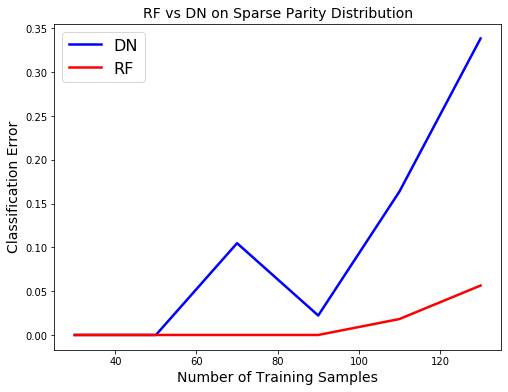

In [33]:
dnn_evolution_mean = np.mean(dnn_evolution_iris, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_iris, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Sparse Parity Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

# fig.savefig('iris.png')

## Sparse Parity Dataset

Sparse parity is a binary classification dataset. It can be thought of as a multivariate generalization of the noisy XOR problem. Creating the dataset requires two parameters: p, the total number of dimensions of the data, and p_star, the number of dimensions within the data that contain useful information about the class label (p_star < p)

In [132]:
X_parity = np.random.uniform(-1, 1, [35000, 13])

<IPython.core.display.Javascript object>

In [133]:
def sparse_parity_labels(X, p_star):
    q = np.zeros(X.shape[0])
    y = np.where(X[:, :3] >= 0, 1, 0)
    return np.sum(y, axis=1) % 2

<IPython.core.display.Javascript object>

In [134]:
y_parity = sparse_parity_labels(X_parity, 5)

<IPython.core.display.Javascript object>

In [135]:
np.array(X_parity, dtype=np.float32).shape

(35000, 13)

<IPython.core.display.Javascript object>

In [ ]:
sample_sizes = [
    500,
    1000,
    2000,
    3000,
    5000,
    7000,
    10000,
    12500,
    15000,
    20000,
    25000,
    30000,
    35000,
]

rf_evolution_parity, dnn_evolution_parity = test_suite(
    X_parity,
    y_parity,
    iterations=8,
    output_nodes=1,
    sample_sizes=sample_sizes,
    num_trees=500,
    rf_verbose=1,
    batch_size=8,
)

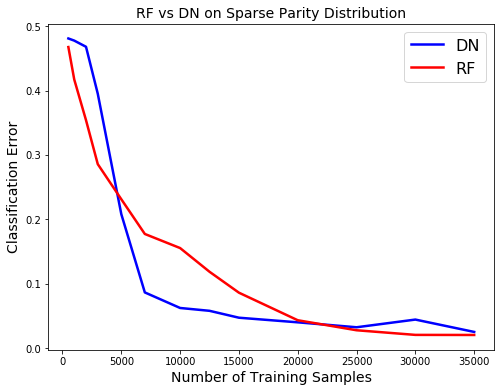

<IPython.core.display.Javascript object>

In [137]:
dnn_evolution_mean = np.mean(dnn_evolution_parity, axis=1)
rf_evolution_mean = np.mean(rf_evolution_parity, axis=1)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, "b", linewidth=2.5)
ax.plot(sample_sizes, rf_evolution_mean, "r", linewidth=2.5)
plt.title("RF vs DN on Sparse Parity Distribution", fontsize=14)
plt.xlabel("Number of Training Samples", fontsize=14)
plt.ylabel("Classification Error", fontsize=14)
plt.legend(["DN", "RF"], prop={"size": 16})

fig.savefig("sparse_parity_p13_5_ss35000_DN_20_8_1_RF_500_trs_8_iters.png")

In [ ]:
sample_sizes = [500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000]

rf_evolution_parity, dnn_evolution_parity = test_suite(X_parity, 
                                                          y_parity, 
                                                          iterations = 5, 
                                                          output_nodes = 1,
                                                          sample_sizes = sample_sizes, 
                                                          num_trees = 500, 
                                                          rf_verbose = 1, 
                                                          batch_size = 8)

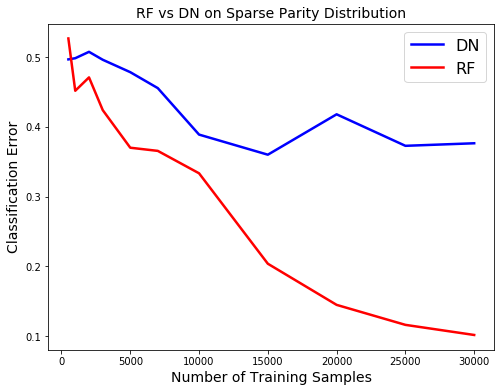

In [21]:
dnn_evolution_mean = np.mean(dnn_evolution_parity, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_parity, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Sparse Parity Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('sparse_parity_DN_2_2_1_RF_500_trs.png')

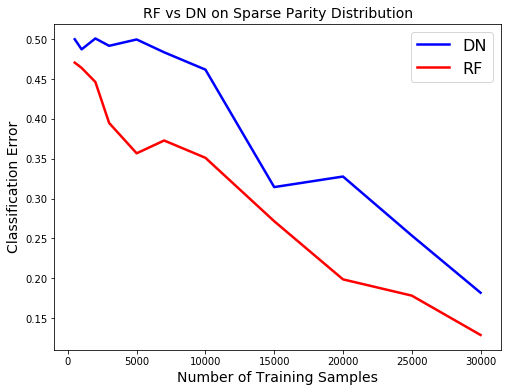

In [10]:
dnn_evolution_mean = np.mean(dnn_evolution_parity, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_parity, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Sparse Parity Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('sparse_parity_DN_4_4_1_RF_500_trs.png')

In [11]:
%store dnn_evolution_parity
%store rf_evolution_parity

Stored 'dnn_evolution_parity' (ndarray)
Stored 'rf_evolution_parity' (ndarray)


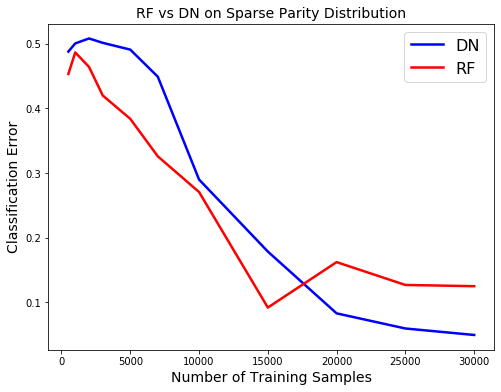

In [12]:
dnn_evolution_mean = np.mean(dnn_evolution_parity, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_parity, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Sparse Parity Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('sparse_parity_DN_8_8_1_RF_500_trs.png')

In [59]:
# First test iteration stored values

# %store dnn_evolution
# %store rf_evolution

# %store -r dnn_evolution
# %store -r rf_evolution


%store dnn_evolution_parity_20000
%store rf_evolution_parity_20000

UsageError: Unknown variable 'dnn_evolution_parity_20000'


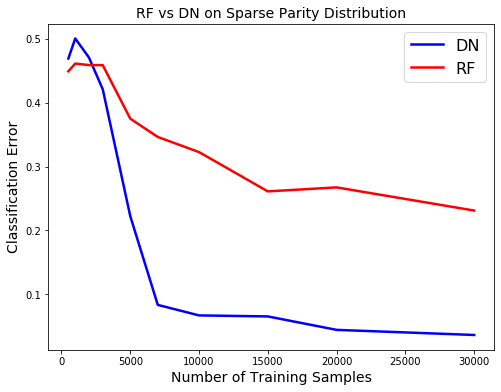

In [15]:
dnn_evolution_mean = np.mean(dnn_evolution, axis = 1)
rf_evolution_mean = np.mean(rf_evolution, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Sparse Parity Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

# fig.savefig('sparse_parity_4_no_extrapolation.png')

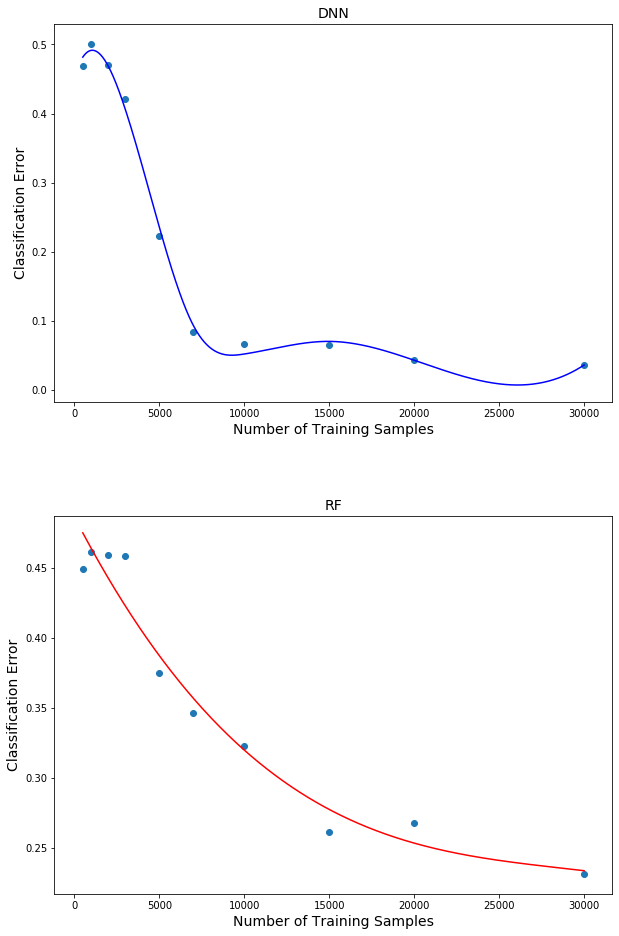

In [7]:
# Fit 1D curve using B-spline representation

from scipy.interpolate import splev, splrep

sample_sizes = [500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000]

X_spline = np.asarray(sample_sizes)
y_spline_dnn = dnn_evolution_mean
y_spline_rf = rf_evolution_mean

x2 = np.linspace(500,30000,1000)

spl_dnn = splrep(X_spline,y_spline_dnn, k=3, s=0.001)
y2_dnn = splev(x2, spl_dnn)

spl_rf = splrep(X_spline,y_spline_rf, k=3, s=0.01)
y2_rf = splev(x2, spl_rf)

fig = plt.figure(figsize = (10,16))

ax = plt.subplot(211)
ax.plot(x2, y2_dnn, 'b')
ax.scatter(X_spline, y_spline_dnn) 
plt.title('DNN', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)

ax = plt.subplot(212)
ax.plot(x2, y2_rf, 'r')
ax.scatter(X_spline, y_spline_rf) 
plt.title('RF', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

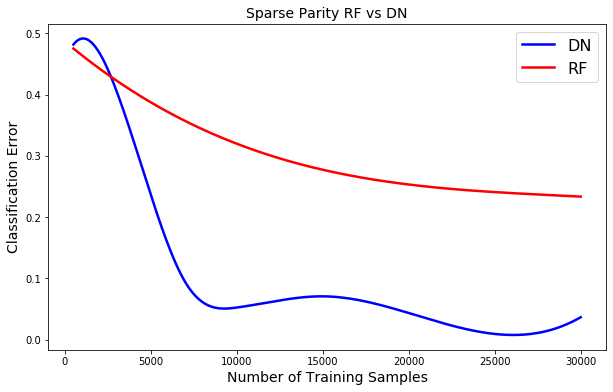

In [46]:
fig = plt.figure(figsize = (10,6))
ax = plt.subplot(111)

ax.plot(x2, y2_dnn, 'b', linewidth = 2.5)
ax.plot(x2, y2_rf, 'r', linewidth = 2.5)

plt.title('Sparse Parity RF vs DN', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('sparse_parity_3.png')

## Orthant Dataset

Orthant is a multiclass classification dataset. Each class label is determined by the orthant of the respective sample, so the total number of classes is equal to 2 ^ p, where p is the total number of dimensions.

In [49]:
def orthant(X, p):
    orthant = np.random.uniform(-1,1,[X,p])
    permutations = np.where(orthant < 0, -1, 1)
    unique_labels = np.unique(permutations, axis=0)

    labels = np.zeros(X)
    for sample_index, sample in enumerate(permutations):
        for label_index, comb in enumerate(unique_labels):
            if np.array_equal(comb, sample):
                labels[sample_index] = label_index
    
    return orthant, labels

In [50]:
X_orthant, y_orthant = orthant(10000, 6)

In [ ]:
sample_sizes = [500, 700, 1000, 1500, 2000, 3000, 4000, 5000, 6500, 8000, 10000]

rf_evolution_orthant, dnn_evolution_orthant = test_suite(X_orthant,
                                                        y_orthant,
                                                        iterations = 5,
                                                        output_nodes = 2**6,
                                                        sample_sizes = sample_sizes,
                                                        num_trees = 500,
                                                        batch_size = 8
                                                        )

In [39]:
%store dnn_evolution_orthant
%store rf_evolution_orthant

# store -r dnn_evolution_orthant
# store -r rf_evolution_orthant

Stored 'dnn_evolution_orthant' (ndarray)
Stored 'rf_evolution_orthant' (ndarray)


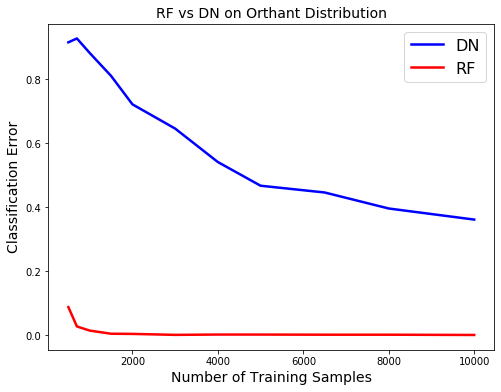

In [52]:
dnn_evolution_mean = np.mean(dnn_evolution_orthant, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_orthant, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Orthant Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('orthant_1_DN_8_8_1_RF_500_trs.png')

## Trunk Dataset

Trunk is a balanced binary classification dataset. Each class is distributed as a p-dimensional multivariate Gaussian with identity covariance matrices. Each value in the mean vector is less than the previous, so each additional dimension is less informative than the last. The mean for class 0 is the negated mean for class 1.

In [62]:
from random import shuffle

def trunk(dimensions, samples):
    cov = np.identity(dimensions)
    
    mu = [1/(i+1) for i in range(dimensions)]
    data_pos = np.random.multivariate_normal(mu, cov, samples)
    labels_pos = [np.ones(samples)]
    
    mu_neg = [-1/(i+1) for i in range(dimensions)]
    data_neg = np.random.multivariate_normal(mu_neg, cov, samples)
    labels_neg = [np.zeros(samples)]

    data = np.concatenate((data_pos, data_neg), axis = 0)
    labels = np.concatenate((np.reshape(labels_pos, samples), np.reshape(labels_neg,samples)), axis = 0)
    
    ind_list = [i for i in range(samples*2)]
    shuffle(ind_list)
    data  = data[ind_list]
    labels = labels[ind_list]

    return data, labels
    

In [63]:
X_trunk, y_trunk = trunk(10, 5000)
X_trunk.shape
y_trunk.shape

(10000,)

In [ ]:
sample_sizes = [700, 1000, 1300, 1600, 2000, 3000, 4000, 5000, 6500, 8000, 10000]

rf_evolution_trunk, dnn_evolution_trunk = test_suite(X_trunk,
                                                        y_trunk,
                                                        iterations = 5,
                                                        output_nodes = 1,
                                                        sample_sizes = sample_sizes,
                                                        num_trees = 500,
                                                        batch_size = 8
                                                        )

In [66]:
%store dnn_evolution_trunk
%store rf_evolution_trunk

# %store -r dnn_evolution_trunk
# %store -r rf_evolution_trunk

Stored 'dnn_evolution_trunk' (ndarray)
Stored 'rf_evolution_trunk' (ndarray)


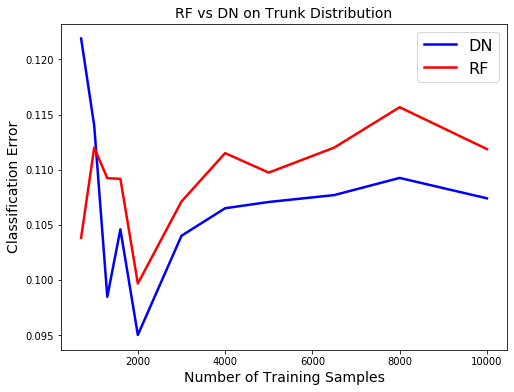

In [65]:
dnn_evolution_mean = np.mean(dnn_evolution_trunk, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_trunk, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on Trunk Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('trunk_1_DN_8_8_1_RF_500_trs.png')

## Noisy XOR

XOR data generated from a uniform distribution from -1 to 1.

In [45]:
def xor(n):
    data = np.random.uniform(-1,1,[n,2])
    labels = np.logical_xor(data[:,0] > 0, data[:,1] > 0).astype('int')
    return data, labels

In [46]:
X_xor, y_xor = xor(10000)

In [ ]:
sample_sizes = [500, 700, 1000, 1500, 2000, 3000, 4000, 5000, 6500, 8000, 10000]

rf_evolution_xor, dnn_evolution_xor = test_suite(X_xor,
                                                        y_xor,
                                                        iterations = 5,
                                                        output_nodes = 1,
                                                        sample_sizes = sample_sizes,
                                                        num_trees = 50,
                                                        batch_size = 8
                                                        )

In [39]:
%store dnn_evolution_xor
%store rf_evolution_xor

# %store -r dnn_evolution_xor
# %store -r rf_evolution_xor

Stored 'dnn_evolution_xor' (ndarray)
Stored 'rf_evolution_xor' (ndarray)


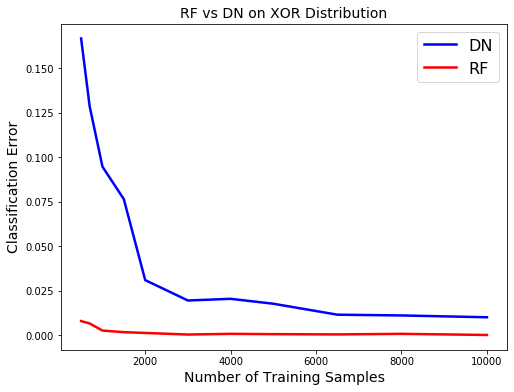

In [48]:
dnn_evolution_mean = np.mean(dnn_evolution_xor, axis = 1)
rf_evolution_mean = np.mean(rf_evolution_xor, axis = 1)

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, 'b', linewidth = 2.5)
ax.plot(sample_sizes, rf_evolution_mean, 'r', linewidth = 2.5)
plt.title('RF vs DN on XOR Distribution', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('xor_1_DN_8_8_1_RF_50_trs.png')